# Notebook description
This notebook uses various Python-based machine learning libraries to build machine learning models capable of predicting the variable Total Volume Deposited from other inkjet printing deposition experimental parameters.

# Loading the libraries and Preprocessing
## Import libraries
Load the libraries necessary to do data preparation and for machine learning.


In [60]:
# EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools

# The Patch library is imported to fix a legend issue, not allowing to show more than one variable
from matplotlib.patches import Patch

# Library to format the axes
import matplotlib.ticker as mtick

# Plots appear in the same notebook cell
%matplotlib inline

# Seaborn style
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper")

# Activate latex text rendering for figure labels
from matplotlib import rc
rc('text', usetex=False)

# Models from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_squared_error

# Tree interpreter
from treeinterpreter import treeinterpreter as ti

# Shap library to explain models intuitively
import shap
shap.initjs() # Activate Javascript option for Jupyter notebooks

# Function to display dataframes side_by_side
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

## Load data
We will load the *data_final.csv* file with the preprocessed data.

In [5]:
# Load dataset
data_final = pd.read_csv("data_final.csv")
data_final.shape

(231, 8)

## Check the dataset
We will check the head and tail of the dataset to confirm it has been loaded correctly.

In [6]:
data_final.head()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Total Volume Deposited (ul),Amine (%)
0,135.0,26.0,185.0,175,75.0,1904.761905,0.352381,1.14
1,110.0,23.0,190.0,200,50.0,2500.000000,0.475000,1.14
2,135.0,26.0,190.0,175,50.0,2857.142857,0.542857,1.14
3,145.0,27.0,220.0,100,100.0,2500.000000,0.550000,1.14
4,130.0,26.0,219.0,95,95.0,2770.083102,0.606648,1.14


In [7]:
data_final.tail()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Total Volume Deposited (ul),Amine (%)
226,155.000000,26.000000,225.0,50,80.0,6250.0,1.40625,2.00
227,155.000000,26.000000,225.0,50,80.0,6250.0,1.40625,2.00
228,155.000000,26.000000,225.0,50,80.0,6250.0,1.40625,2.00
229,153.500000,25.500000,238.0,50,80.0,6250.0,1.48750,2.00
230,149.873239,25.507042,180.0,50,50.0,10000.0,1.80000,1.14


## Prediction of the variable **Total Volume Deposited**
We will build a machine learning model to predict the **Total Volume Deposited** by considering all the variables from the dataset.

### Select model variables
We will select the variables used in the model, shuffle the data, and split the dataset into X and y.

In [8]:
# Drop columns
data_TVD = data_final

# Check the dataset
data_TVD

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Total Volume Deposited (ul),Amine (%)
0,135.000000,26.000000,185.0,175,75.0,1904.761905,0.352381,1.14
1,110.000000,23.000000,190.0,200,50.0,2500.000000,0.475000,1.14
2,135.000000,26.000000,190.0,175,50.0,2857.142857,0.542857,1.14
3,145.000000,27.000000,220.0,100,100.0,2500.000000,0.550000,1.14
4,130.000000,26.000000,219.0,95,95.0,2770.083102,0.606648,1.14
...,...,...,...,...,...,...,...,...
226,155.000000,26.000000,225.0,50,80.0,6250.000000,1.406250,2.00
227,155.000000,26.000000,225.0,50,80.0,6250.000000,1.406250,2.00
228,155.000000,26.000000,225.0,50,80.0,6250.000000,1.406250,2.00
229,153.500000,25.500000,238.0,50,80.0,6250.000000,1.487500,2.00


In [9]:
# Shuffle the data
data_TVD = shuffle(data_TVD, random_state = 42) # A random state was set to keep the results reproducible

data_TVD.reset_index(inplace = True, drop = True)

We shuffle the data to ensure there is no influence on how the data has been introduced in the dataset on the model results.

In [10]:
# Split the data set into X and y
X_TVD = data_TVD.drop(labels=['Total Volume Deposited (ul)'], axis=1)
y_TVD = data_TVD['Total Volume Deposited (ul)']

### Train/test splitting
We split the data into train and test datasets by using the ratio 80:20.

In [11]:
# Split the training data into training and test sets (80:20)
X_train_TVD, X_test_TVD, y_train_TVD, y_test_TVD = train_test_split(X_TVD,
                                                  y_TVD,
                                                  test_size=0.2, random_state = 42)

In [12]:
# Check the range of values from all columns
X_train_TVD.describe()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Amine (%)
count,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000,184.000000
mean,150.313036,25.571226,203.336957,100.326087,67.562500,4976.595225,1.652391
std,22.363363,1.031120,19.421498,62.054112,25.930804,1224.097682,0.416547
min,95.000000,20.000000,140.000000,45.000000,20.000000,1904.761905,0.000000
25%,136.000000,25.000000,190.000000,50.000000,40.000000,3906.250000,1.140000
50%,149.936620,25.507042,205.000000,80.000000,80.000000,5000.000000,2.000000
75%,155.000000,26.000000,220.000000,160.000000,85.000000,5882.352941,2.000000
max,234.000000,30.000000,240.000000,250.000000,100.000000,10000.000000,2.300000


In [13]:
# Check the range of values from all columns
X_test_TVD.describe()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Amine (%)
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,148.151483,25.255769,202.957447,107.659574,63.191489,5044.874953,1.668085
std,20.718978,1.272166,19.617492,64.898341,27.295197,1219.078954,0.400166
min,95.000000,20.000000,165.000000,45.000000,20.000000,3246.753247,1.140000
25%,137.500000,25.000000,188.500000,50.000000,35.000000,3906.250000,1.140000
50%,150.000000,25.500000,202.500000,85.000000,75.000000,5000.000000,2.000000
75%,157.500000,26.000000,220.000000,160.000000,85.000000,6250.000000,2.000000
max,233.000000,27.000000,235.000000,245.000000,110.000000,7407.407407,2.300000


In [14]:
# Check the range of values from all columns
y_train_TVD.describe()

count    184.000000
mean       0.997871
std        0.203188
min        0.352381
25%        0.839844
50%        1.000000
75%        1.152941
max        1.800000
Name: Total Volume Deposited (ul), dtype: float64

In [15]:
# Check the range of values from all columns
y_test_TVD.describe()

count    47.000000
mean      1.007116
std       0.189097
min       0.714286
25%       0.834961
50%       0.989583
75%       1.184028
max       1.406250
Name: Total Volume Deposited (ul), dtype: float64

### Build models without hyperparameters
We will build the models with all default hyperparameters.

In [16]:
# Dictionary with models
models = {
          'Linear Regression': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'AdaBoost Regressor': AdaBoostRegressor(),
          'Gradient Boosting': GradientBoostingRegressor()
         }

# Create a function to fit and score models
def train_cross_val(models, X_train, y_train, score_name):
   
    # Set random seed
    np.random.seed(42)
    
    # Make a dictionary to keep model scores
    model_validation_scores = {}

    # K-Fold cross validation
    cv = KFold(n_splits = 5) # n_splits = 5 means 80:20 training:validation
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the training data
        model.fit(X_train, y_train)
        
        # Cross-validation
        model_validation_scores[name] = cross_validate(model, X_train, y_train, 
                                                       cv = cv, scoring = score_name, return_train_score = True)
         
    return model_validation_scores

In [17]:
# Check scores
cross_val_scores = train_cross_val(models=models, X_train=X_train_TVD, y_train=y_train_TVD, score_name='r2')

{'Linear Regression': {'fit_time': array([0.0129962 , 0.01800227, 0.02500463, 0.01599813, 0.01808095]),
  'score_time': array([0.00800037, 0.00999546, 0.00985575, 0.00800371, 0.01299   ]),
  'test_score': array([0.98666262, 0.99021953, 0.98846892, 0.98634371, 0.98825806]),
  'train_score': array([0.9894256 , 0.98877003, 0.98915919, 0.98961793, 0.98910605])},
 'Random Forest': {'fit_time': array([0.76778054, 0.68134046, 0.49863052, 0.91240382, 0.73224998]),
  'score_time': array([0.06498742, 0.03201056, 0.03700352, 0.03100872, 0.0610013 ]),
  'test_score': array([0.95074338, 0.97871859, 0.83804203, 0.96832894, 0.93174362]),
  'train_score': array([0.99181631, 0.98927432, 0.99434013, 0.98860905, 0.99022721])},
 'AdaBoost Regressor': {'fit_time': array([0.34401536, 0.28700638, 0.28420854, 0.33100247, 0.27398872]),
  'score_time': array([0.03900003, 0.01999116, 0.03765774, 0.05199504, 0.0179987 ]),
  'test_score': array([0.90441976, 0.93013617, 0.80347192, 0.93261257, 0.86299135]),
  'trai

In [ ]:
# Get values from each model
def get_dict_scores():
    
    # Define empty dictionaries
    train_score = {}
    test_score = {}
    
    # Loop through score dictionary values
    for k1, v1 in cross_val_scores.items():
        for k2, v2 in v1.items():
            if k2 == 'train_score':
                v2 = np.mean(v2)
                train_score[k1] = abs(v2)
            elif k2 == 'test_score':
                v2 = np.mean(v2)
                test_score[k1] = abs(v2)         
    
    return train_score, test_score

In [ ]:
# Define function to merge scores and create a dataframe
def merge_scores():
    
    dict_scores = get_dict_scores()
    train_score = dict_scores[0]
    test_score = dict_scores[1]
    
    # Create a data frame with the scores from the train_score dictionary
    train_df = pd.DataFrame.from_dict(train_score, orient='index')
    train_df.reset_index(inplace = True)
    train_df = train_df.rename(columns = {'index': 'Models', 0: 'Avg. Score'})
    
    # Create a data frame with the scores from the test_score dictionary
    test_df = pd.DataFrame.from_dict(test_score, orient='index')
    test_df.reset_index(inplace = True)
    test_df = test_df.rename(columns = {'index': 'Models', 0: 'Avg. Score'})
    
    # Merge both dataframes
    df = pd.merge(train_df, test_df[['Models','Avg. Score']],on='Models', how='left')
    df = df.rename(columns = {'Avg. Score_x': 'Train Avg. Score', 'Avg. Score_y': 'Test Avg. Score'})

    # Melt dictionary by Models column
    model_compare = df.melt(id_vars = 'Models')
    model_compare = model_compare.rename(columns = {'variable': 'Score', 'value': 'Value'})
    
    return model_compare

merge_scores()

In [ ]:
def plot_scores():
    
    # Call the merge_scores function
    model_compare = merge_scores()
    
    # Plot the scores
    fig, ax = plt.subplots(figsize=(7,5))

    sns.barplot(x = 'Models', y = 'Value', data = model_compare, hue = 'Score', palette = 'Blues_d', ax = ax)

    plt.xticks(fontsize=20, rotation=90);
    plt.xlabel("", fontsize=20);
    plt.yticks(fontsize=18);
    plt.ylabel(r"R$^2$", fontsize=20);

    plt.ylim([0, 1.1])
    plt.yticks(np.arange(0, 1.2, 0.2))

    model_names = ['Linear \nRegression', 'Random \nForest', 'AdaBoost \nRegressor', 'Gradient \nBoosting']
    ax.set_xticklabels(model_names)

    plt.legend(prop={"size":16}, loc = 4)

    x_offset = 0.00
    y_offset = 0.00

    for p in ax.patches:
        ax.annotate(str(round(p.get_height(),2)), (p.get_x() + 0.02, p.get_height() * 1.005), fontsize = 18)
        
    return plt.show()

plot_scores()

### Evaluation function to calculate different error metrics

In [20]:
# Create function to evaluate our model
def show_scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Train MSE": mean_squared_error(y_train, train_preds, squared=True),
              "Test MSE": mean_squared_error(y_test, val_preds, squared=True),
              "Train RMSE": mean_squared_error(y_train, train_preds, squared=False),
              "Test RMSE": mean_squared_error(y_test, val_preds, squared=False),
              "Train R^2": model.score(X_train, y_train),
              "Test R^2": model.score(X_test, y_test)}
    return scores

### Optimizing the Random Forest Regressor
We will optimize the hyperparameters for the Random Forest Regressor model, as well as explore the evolution of different metrics.

#### Number of estimators
Here, we will plot the evolution of the RMSE and R$^2$ as a function of the *n_estimators*, *min_sample_split* and *max_depth parameters*. 

In [21]:
# Function to evaluate the hyperparameters for the number of trees
def n_trees_tuning(X_train, y_train, n_trees, tree_step, cross_val):

    ### Iterate over the number of estimators in the Random Forest

    # Create a list to store the metrics
    index_estimators = []
    r2_estimators = []
    rmse_estimators = []

    cv = KFold(n_splits = cross_val) # n_splits = 5 means 80:20 training:validation

    # Iterate over a hyperparameter
    for i in np.arange(0, n_trees, tree_step):
        test_model_rf_NOD = RandomForestRegressor(n_estimators = i,
                                        min_samples_leaf = 1,
                                        min_samples_split = 3,
                                        max_features = 'auto',
                                        max_depth = 10,
                                        max_samples = None,
                                        random_state = 42)
        
        val_scores_r2 = cross_val_score(test_model_rf_NOD, X_train, y_train, cv = cv, scoring = 'r2')
        val_scores_rmse = cross_val_score(test_model_rf_NOD, X_train, y_train, cv = cv, 
                                        scoring = 'neg_root_mean_squared_error')

        # Store the scores in a list
        index_estimators.append(i)
        r2_estimators.append(val_scores_r2.mean())
        rmse_estimators.append(val_scores_rmse.mean())

    return index_estimators, r2_estimators, rmse_estimators

In [ ]:
index_estimators, r2_estimators, rmse_estimators = n_trees_tuning(X_train_TVD, y_train_TVD, n_trees = 500, tree_step = 10, cross_val = 5)

In [22]:
# Create a dataframe with the number of estimators
rf_estimators_TVD = pd.DataFrame(
    {
        'Nº of Estimators': index_estimators,
        'R2 validation': r2_estimators,
        'RMSE validation': rmse_estimators
    }
)

# Convert negative RMSE to positive
rf_estimators_TVD['RMSE validation'] = rf_estimators_TVD['RMSE validation'].abs()

In [23]:
# Function to evaluate the hyperparameters for the number of trees
def split_tuning(X_train, y_train, min_split, split_step, cross_val):

    ### Iterate over the min_sample_split in the Random Forest

    # Create a list to store the metrics
    index_min_sample = []
    rmse_min_sample = []
    r2_min_sample = []

    cv = KFold(n_splits = cross_val) # n_splits = 5 means 80:20 training:validation

    # Iterate over a hyperparameter
    for i in np.arange(2, min_split, split_step):
        test_model_rf_NOD = RandomForestRegressor(n_estimators = 30,
                                        min_samples_leaf = 1,
                                        min_samples_split = i,
                                        max_features = 'auto',
                                        max_depth = 10,
                                        max_samples = None,
                                        random_state = 42)
        
        val_scores_r2_min_sample = cross_val_score(test_model_rf_NOD, X_train, y_train, 
                                                cv = cv, scoring = 'r2')
        val_scores_rmse_min_sample = cross_val_score(test_model_rf_NOD, X_train, y_train, 
                                                    cv = cv, scoring = 'neg_root_mean_squared_error')
        
        # Store the scores in a list
        index_min_sample.append(i)
        r2_min_sample.append(val_scores_r2_min_sample.mean())
        rmse_min_sample.append(val_scores_rmse_min_sample.mean())

    return index_min_sample, r2_min_sample, rmse_min_sample

In [ ]:
index_min_sample, r2_min_sample, rmse_min_sample = split_tuning(X_train_TVD, y_train_TVD, min_split = 10, split_step = 1, cross_val = 5)

In [24]:
# Create a dataframe with the min_sample_split
rf_split_TVD = pd.DataFrame(
    {
        'Minimum Sample Split': index_min_sample,
        'R2 validation': r2_min_sample,
        'RMSE validation': rmse_min_sample
    }
)

# Convert negative RMSE to positive
rf_split_TVD['RMSE validation'] = rf_split_TVD['RMSE validation'].abs()

In [25]:
# Function to evaluate the hyperparameters for the number of trees
def depth_tuning(X_train, y_train, depth, depth_step, cross_val):
    ### Iterate over the max_depth in the Random Forest

    # Create a list to store the metrics
    index_depth = []
    rmse_depth = []
    r2_depth = []

    cv = KFold(n_splits = cross_val) # n_splits = 5 means 80:20 training:validation

    # Iterate over a hyperparameter
    for i in np.arange(2, depth, depth_step):
        test_model_rf_NOD = RandomForestRegressor(n_estimators = 30,
                                        min_samples_leaf = 1,
                                        min_samples_split = 3,
                                        max_features = 'auto',
                                        max_depth = i,
                                        max_samples = None,
                                        random_state = 42)
        val_scores_r2_depth = cross_val_score(test_model_rf_NOD, X_train, y_train, 
                                            cv = cv, scoring = 'r2')
        val_scores_rmse_depth = cross_val_score(test_model_rf_NOD, X_train, y_train, 
                                                cv = cv, scoring = 'neg_root_mean_squared_error')
        
        # Store the scores in a list
        index_depth.append(i)
        r2_depth.append(val_scores_r2_depth.mean())
        rmse_depth.append(val_scores_rmse_depth.mean())

    return index_depth, r2_depth, rmse_depth

In [ ]:
index_depth, r2_depth, rmse_depth = depth_tuning(X_train_TVD, y_train_TVD, depth=20, depth_step=1, cross_val=5)

In [26]:
# Create a dataframe with the max_depth
rf_depth_TVD = pd.DataFrame(
    {
        'Maximum Depth': index_depth,
        'R2 validation': r2_depth,
        'RMSE validation': rmse_depth
    }
)

# Convert negative RMSE to positive
rf_depth_TVD['RMSE validation'] = rf_depth_TVD['RMSE validation'].abs()

### Figure S9

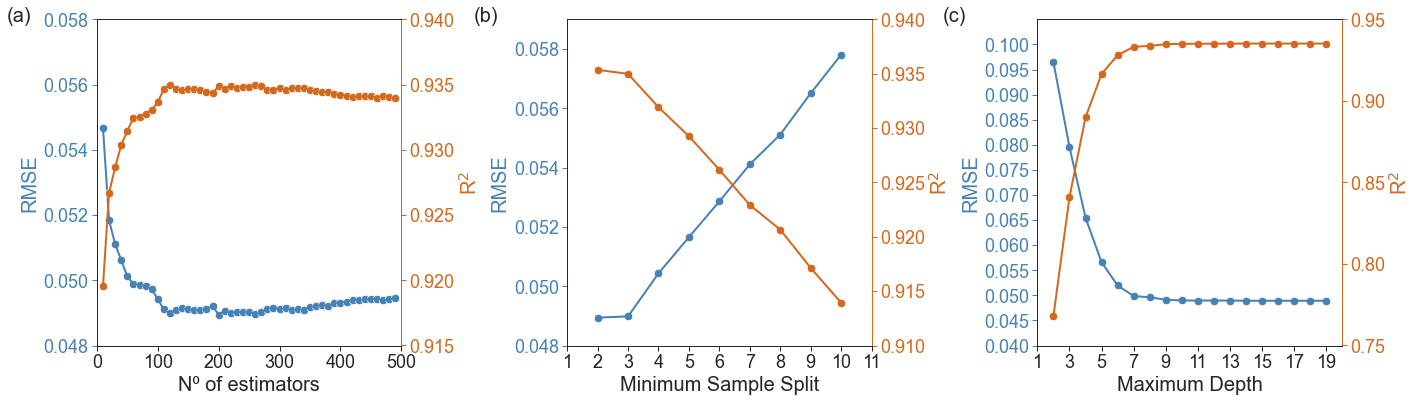

In [27]:
# Define the grid
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(14,4))

# Plot the different metrics as a function of the number of estimators
g1_rmse_scatter = sns.scatterplot(x = 'Nº of Estimators', y = 'RMSE validation', s=70, 
                                  color = 'steelblue', data = rf_estimators_TVD, ax = axs[0])
g1_rmse_line = sns.lineplot(x = 'Nº of Estimators', y = 'RMSE validation', linewidth = 2, 
                            color = 'steelblue', data = rf_estimators_TVD, ax = axs[0])

# Twin object for two different y-axis on the sample plot axs[0]
ax1_twin=axs[0].twinx()

g1_r2_scatter = sns.scatterplot(x = 'Nº of Estimators', y = 'R2 validation', s=70, 
                                color = 'chocolate', data = rf_estimators_TVD, ax = ax1_twin)
g1_r2_line = sns.lineplot(x = 'Nº of Estimators', y = 'R2 validation', linewidth = 2, 
                          color = 'chocolate', data = rf_estimators_TVD, ax = ax1_twin)

# Plot the different metrics as a function of the minimum sample split
g2_rmse_scatter = sns.scatterplot(x = 'Minimum Sample Split', y = 'RMSE validation', s=70, 
                                  color = 'steelblue', data = rf_split_TVD, ax = axs[1])
g2_rmse_line = sns.lineplot(x = 'Minimum Sample Split', y = 'RMSE validation', linewidth = 2, 
                            color = 'steelblue', data = rf_split_TVD, ax = axs[1])

# Twin object for two different y-axis on the sample plot axs[1]
ax2_twin=axs[1].twinx()

g2_r2_scatter = sns.scatterplot(x = 'Minimum Sample Split', y = 'R2 validation', s=70, 
                                color = 'chocolate', data = rf_split_TVD, ax = ax2_twin)
g2_r2_line = sns.lineplot(x = 'Minimum Sample Split', y = 'R2 validation', linewidth = 2, 
                          color = 'chocolate', data = rf_split_TVD, ax = ax2_twin)

# Plot the different metrics as a function of the maximum depth
g3_rmse_scatter = sns.scatterplot(x = 'Maximum Depth', y = 'RMSE validation', s=70, 
                                  color = 'steelblue', data = rf_depth_TVD, ax = axs[2])
g3_rmse_line = sns.lineplot(x = 'Maximum Depth', y = 'RMSE validation', linewidth = 2, 
                            color = 'steelblue', data = rf_depth_TVD, ax = axs[2])

# Twin object for two different y-axis on the sample plot axs[2]
ax3_twin=axs[2].twinx()

g3_r2_scatter = sns.scatterplot(x = 'Maximum Depth', y = 'R2 validation', s=70, 
                                color = 'chocolate', data = rf_depth_TVD, ax = ax3_twin)
g3_r2_line = sns.lineplot(x = 'Maximum Depth', y = 'R2 validation', linewidth = 2, 
                          color = 'chocolate', data = rf_depth_TVD, ax = ax3_twin)

### Customize the axs[0] plot

# Customize the RMSE plot
axs[0].set_xlabel('Nº of estimators', fontsize = 20)
axs[0].set_ylabel('RMSE', fontsize = 20, color = 'steelblue')
axs[0].tick_params(labelsize = 18)
axs[0].set_xlim([0, 500])
axs[0].set_ylim([0.048, 0.056])
axs[0].set_xticks(np.arange(0, 510, 100))
axs[0].set_yticks(np.arange(0.048, 0.06, 0.002))
axs[0].spines['left'].set_color('steelblue')
axs[0].tick_params(axis='y', colors='steelblue')

# Customize the R2 plot
ax1_twin.set_ylabel(r'R$^2$', fontsize = 20, color = 'chocolate')
ax1_twin.tick_params(axis = 'y', labelsize = 18)
ax1_twin.set_ylim([0.915, 0.94])
ax1_twin.set_yticks(np.arange(0.915, 0.945, 0.005))
ax1_twin.spines['right'].set_color('chocolate')
ax1_twin.tick_params(axis='y', colors='chocolate')

### Customize the axs[1] plot

# Customize the RMSE plot
axs[1].set_xlabel('Minimum Sample Split', fontsize = 20)
axs[1].set_ylabel('RMSE', fontsize = 20, color = 'steelblue')
axs[1].tick_params(labelsize = 18)
axs[1].set_xlim([1, 11])
axs[1].set_ylim([0.048, 0.059])
axs[1].set_xticks(np.arange(1, 12, 1))
axs[1].set_yticks(np.arange(0.048, 0.06, 0.002))
axs[1].spines['left'].set_color('steelblue')
axs[1].tick_params(axis='y', colors='steelblue')

# Customize the R2 plot
ax2_twin.set_ylabel(r'R$^2$', fontsize = 20, color = 'chocolate')
ax2_twin.tick_params(axis = 'y', labelsize = 18, color = 'chocolate')
ax2_twin.set_ylim([0.91, 0.94])
ax2_twin.set_yticks(np.arange(0.91, 0.945, 0.005))
ax2_twin.spines['right'].set_color('chocolate')
ax2_twin.tick_params(axis='y', colors='chocolate')

### Customize the axs[2] plot

# Customize the RMSE plot
axs[2].set_xlabel('Maximum Depth', fontsize = 20)
axs[2].set_ylabel('RMSE', fontsize = 20, color = 'steelblue')
axs[2].tick_params(labelsize = 18)
axs[2].set_xlim([1, 20])
axs[2].set_ylim([0.04, 0.105])
axs[2].set_xticks(np.arange(1, 21, 2))
axs[2].set_yticks(np.arange(0.04, 0.105, 0.005))
axs[2].spines['left'].set_color('steelblue')
axs[2].tick_params(axis='y', colors='steelblue')

# Customize the R2 plot
ax3_twin.set_ylabel(r'R$^2$', fontsize = 20, color = 'chocolate')
ax3_twin.tick_params(axis = 'y', labelsize = 18, color = 'chocolate')
ax3_twin.set_ylim([0.75, 0.95])
ax3_twin.set_yticks(np.arange(0.75, 0.96, 0.05))
ax3_twin.spines['right'].set_color('chocolate')
ax3_twin.tick_params(axis='y', colors='chocolate')

# Figure labels
fig.text(-0.003, 1.35, '(a)', va='center', rotation='horizontal', fontsize = 20)
fig.text(0.46, 1.35, '(b)', va='center', rotation='horizontal', fontsize = 20)
fig.text(0.925, 1.35, '(c)', va='center', rotation='horizontal', fontsize = 20)

# set the spacing between subplots 
plt.subplots_adjust(left=0.0, 
                    bottom=0.0,  
                    right=0.9,  
                    top=0.9,  
                    wspace=2.5,  
                    hspace=0.5)

plt.tight_layout(rect=(0, 0, 1.4, 1.4));

### Train a model with the best parameters
The Random Forest will be trained on the best parameters to calculate the values of the evaluation metrics. Then, it will be fit to the whole train set and evaluated to a final test set.

In [28]:
%%time
cv = KFold(n_splits = 5) # n_splits = 5 means 80:20 training:validation

# Most ideal hyperparameters
ideal_model_rf_TVD = RandomForestRegressor(n_estimators = 120,
                                    min_samples_leaf = 1,
                                    min_samples_split = 3,
                                    max_features = 'auto',
                                    max_depth = 10,
                                    max_samples = None,
                                    random_state = 42)

val_scores_r2 = cross_validate(ideal_model_rf_TVD, X_train_TVD, y_train_TVD, 
                               cv = cv, scoring = 'r2', return_train_score = True)
val_scores_rmse = cross_validate(ideal_model_rf_TVD, X_train_TVD, y_train_TVD, 
                                 cv = cv, scoring = 'neg_root_mean_squared_error', return_train_score = True)

# Scores
val_scores_r2
val_scores_rmse

Wall time: 7.41 s


{'fit_time': array([0.612427  , 0.60246205, 0.76193666, 0.55800128, 0.68872142]),
 'score_time': array([0.04000092, 0.04300308, 0.07200098, 0.05000114, 0.05199862]),
 'test_score': array([-0.04035831, -0.02788103, -0.08971016, -0.0358721 , -0.05108857]),
 'train_score': array([-0.02077078, -0.02049286, -0.0156528 , -0.0239474 , -0.02102809])}

#### Calculate mean value of R2

In [29]:
# Train score
val_scores_r2['train_score'].mean()

0.9897566797134786

In [30]:
# Validation score
val_scores_r2['test_score'].mean()

0.9349832073334448

#### Calculate mean value of RMSE

In [31]:
# Train score
abs(val_scores_rmse['train_score'].mean())

0.020378387569141506

In [32]:
# Validation score
abs(val_scores_rmse['test_score'].mean())

0.04898203686734022

#### Fit the model on the whole training set and calculate the scores for the test set

In [33]:
# Fit the ideal model on the whole training set
ideal_model_rf_TVD.fit(X_train_TVD, y_train_TVD)

# Calculate the scores for the test set
ideal_scores_TVD = show_scores(ideal_model_rf_TVD, X_train_TVD, X_test_TVD, y_train_TVD, y_test_TVD)
ideal_scores_TVD

{'Train MSE': 0.0004306294104637352,
 'Test MSE': 0.0006719451266191936,
 'Train RMSE': 0.020751612237696983,
 'Test RMSE': 0.02592190437871403,
 'Train R^2': 0.9895124495083429,
 'Test R^2': 0.9807997815771013}

The scores for the train set shown here correspond to the ones for the whole set without cross-validation.

#### Predictions with the optimized model and graphical representation

In [34]:
# Make predictions on test data and save them
y_preds_rf_TVD = ideal_model_rf_TVD.predict(X_test_TVD)

# View predictions
y_preds_rf_TVD

array([0.90299627, 1.13915195, 1.02786235, 1.21174913, 1.04991181,
       1.12238724, 0.7401665 , 0.83009169, 1.23507004, 1.28731813,
       1.05717336, 1.17993053, 1.2703229 , 0.73406211, 0.839898  ,
       1.17465022, 0.91298685, 1.20262267, 0.96929794, 0.85921224,
       0.93264768, 0.83009169, 0.80354471, 1.21427637, 1.30197885,
       1.40994589, 0.9004008 , 0.96935473, 1.00062976, 0.98339192,
       0.74525806, 0.85650725, 0.80354471, 0.97980494, 1.05702306,
       1.11782456, 1.242989  , 0.7165456 , 0.81265835, 1.22776114,
       0.88919639, 1.14475696, 0.74862447, 1.20509222, 1.21984571,
       0.80354471, 0.95336925])

(0.6, 1.5)

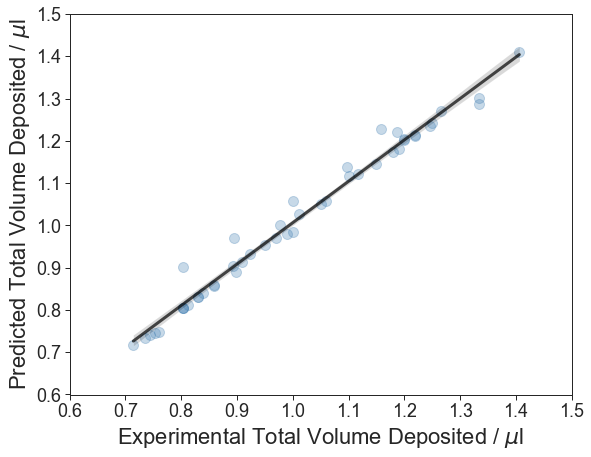

In [35]:
# Plot Y-train vs Y-preds for RFR
fig, ax = plt.subplots(figsize=(9, 7))

sns.regplot(x = y_test_TVD,
            y= y_preds_rf_TVD, scatter_kws={"color":"steelblue","alpha":0.3,"s":100}, 
            line_kws={"color":"black","alpha":0.7,"lw":3});

ax.tick_params(labelsize=18)
ax.set_xlabel(r"Experimental Total Volume Deposited / $\mu$l",fontsize=22)
ax.set_ylabel(r"Predicted Total Volume Deposited / $\mu$l",fontsize=22)

plt.xticks(np.arange(0.6, 1.6, 0.1))
plt.yticks(np.arange(0.6, 1.6, 0.1))
plt.xlim([0.6, 1.5])
plt.ylim([0.6, 1.5])

The above plot with the results from the predictions vs the experimentally determined Total Deposited Volume shows that the model can predict with high accuracy the experimental values, as expected due to the high accuracy obtained.

### Calculation of the variable importance
We will plot the variable importance which lists the variables of the model by order of importance in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power. The SHAP library is being used to calculate it, and it is based on the mean absolute value of the SHAP values for each feature.

Check https://github.com/slundberg/shap for details on the implementation of the SHAP library.

### Figure 7a

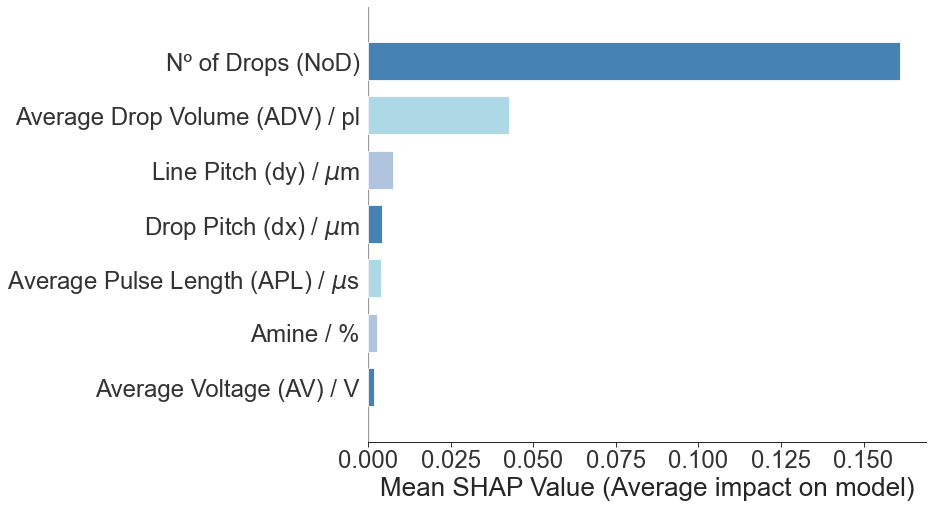

In [36]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(ideal_model_rf_TVD)
shap_values = explainer.shap_values(X_train_TVD)
shap.summary_plot(shap_values, X_train_TVD, color = ["steelblue", "lightsteelblue", "lightblue"], 
                  plot_type="bar", show=False)

# Customize SHAP plot
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(10)
ax = plt.gca()
ax.set_xlabel(r'Mean SHAP Value (Average impact on model)', fontsize=26)
ax.tick_params(labelsize=24)

var_shap = ['Average Voltage (AV) / V', 'Amine / %', r'Average Pulse Length (APL) / $\mu$s', 
            r'Drop Pitch (dx) / $\mu$m', r'Line Pitch (dy) / $\mu$m', 
            'Average Drop Volume (ADV) / pl', 'Nº of Drops (NoD)']

ax.set_yticklabels(var_shap)

plt.show()

Variable importance shows that the Nº of drops and average drop volume are the most important variables contributing in building the model, while the remaining variables have very little influence in the model and could be discarded from the model without affecting too much its predictive power.

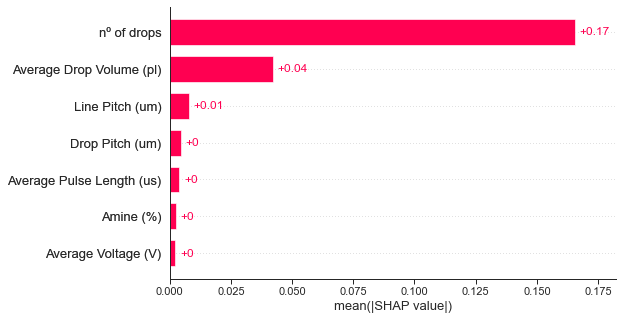

In [37]:
shap.plots.bar(explainer(X_test_TVD))

## Prediction of the variable **Total Volume Deposited** by dropping unimportant features
We will remove the previous unimportant variables from the model to determine how the accuracy and RMSE vary.

In [38]:
# Drop columns from train and test sets
X_train_TVD_reduced = X_train_TVD.drop(labels=[
                                 'Average Voltage (V)', 'Average Pulse Length (us)', 'Amine (%)', 
                                 'Drop Pitch (um)', 'Line Pitch (um)'
                                ], axis=1, inplace=False)

X_test_TVD_reduced = X_test_TVD.drop(labels=[
                                 'Average Voltage (V)', 'Average Pulse Length (us)', 'Amine (%)', 
                                 'Drop Pitch (um)', 'Line Pitch (um)'
                                ], axis=1, inplace=False)

### Train a new model with the reduced dataset
We will train a RF model with the reduced dataset

In [39]:
%%time
cv = KFold(n_splits = 5) # n_splits = 5 means 80:20 training:validation

# Most ideal hyperparameters
ideal_model_rf_TVD_reduced = RandomForestRegressor(n_estimators = 120,
                                    min_samples_leaf = 1,
                                    min_samples_split = 3,
                                    max_features = 'auto',
                                    max_depth = 10,
                                    max_samples = None,
                                    random_state = 42)
ideal_model_rf_TVD_reduced.fit(X_train_TVD_reduced, y_train_TVD)

val_scores_r2_reduced = cross_validate(ideal_model_rf_TVD_reduced, X_train_TVD_reduced, 
                                       y_train_TVD, cv = cv, scoring = 'r2', return_train_score = True)
val_scores_rmse_reduced = cross_validate(ideal_model_rf_TVD_reduced, X_train_TVD_reduced, 
                                         y_train_TVD, cv = cv, scoring = 'neg_root_mean_squared_error', 
                                         return_train_score = True)

# Scores
val_scores_r2_reduced
val_scores_rmse_reduced

Wall time: 9.02 s


{'fit_time': array([0.59231067, 1.09739017, 0.67203569, 0.46781874, 0.51846027]),
 'score_time': array([0.03599787, 0.03200316, 0.03699565, 0.03599715, 0.03300405]),
 'test_score': array([-0.02551712, -0.02361607, -0.07968134, -0.02450029, -0.0413976 ]),
 'train_score': array([-0.0180293 , -0.01782074, -0.0127044 , -0.02054952, -0.01817215])}

#### Calculate mean value of R2

In [40]:
# Train score
val_scores_r2_reduced['train_score'].mean()

0.9924591190019584

In [41]:
# Validation score
val_scores_r2_reduced['test_score'].mean()

0.9567293713442984

#### Calculate mean value of RMSE

In [42]:
# Train score
abs(val_scores_rmse_reduced['train_score'].mean())

0.01745522148464957

In [43]:
# Validation score
abs(val_scores_rmse_reduced['test_score'].mean())

0.03894248535911965

In [44]:
scores_TVD_reduced = show_scores(ideal_model_rf_TVD_reduced, X_train_TVD_reduced, X_test_TVD_reduced, 
                                 y_train_TVD, y_test_TVD)
scores_TVD_reduced

{'Train MSE': 0.0003150890671527711,
 'Test MSE': 0.00046144357239286116,
 'Train RMSE': 0.017750748354724965,
 'Test RMSE': 0.021481237682984218,
 'Train R^2': 0.9923263195201293,
 'Test R^2': 0.9868146712747772}

#### Plot model accuracy and RMSE for full dataset vs reduced dataset

In [45]:
ideal_scores_TVD

{'Train MSE': 0.0004306294104637352,
 'Test MSE': 0.0006719451266191936,
 'Train RMSE': 0.020751612237696983,
 'Test RMSE': 0.02592190437871403,
 'Train R^2': 0.9895124495083429,
 'Test R^2': 0.9807997815771013}

In [46]:
# Create dataframe with scores from full dataset
ideal_scores_TVD_df = pd.DataFrame.from_dict(ideal_scores_TVD, orient = 'index', columns = ['Value'])
ideal_scores_TVD_df.reset_index(drop = False, inplace = True)
ideal_scores_TVD_df = ideal_scores_TVD_df.rename(columns = {'index':'Metric'})
ideal_scores_TVD_df.drop([ideal_scores_TVD_df.index[0], ideal_scores_TVD_df.index[1]], inplace = True)
ideal_scores_TVD_df.reset_index(drop = True, inplace = True)

In [47]:
ideal_scores_TVD_df

,Metric,Value
0,Train RMSE,0.020752
1,Test RMSE,0.025922
2,Train R^2,0.989512
3,Test R^2,0.980800


In [48]:
# Create dataframe with scores from reduced dataset
reduced_scores_TVD_df = pd.DataFrame.from_dict(scores_TVD_reduced, orient = 'index', columns = ['Value'])
reduced_scores_TVD_df.reset_index(drop = False, inplace = True)
reduced_scores_TVD_df = reduced_scores_TVD_df.rename(columns = {'index':'Metric'})
reduced_scores_TVD_df.drop([reduced_scores_TVD_df.index[0], reduced_scores_TVD_df.index[1]], inplace = True)
reduced_scores_TVD_df.reset_index(drop = True, inplace = True)

In [49]:
reduced_scores_TVD_df

,Metric,Value
0,Train RMSE,0.017751
1,Test RMSE,0.021481
2,Train R^2,0.992326
3,Test R^2,0.986815


In [50]:
# Concatenate dataframes
concat_scores_TVD = pd.concat([ideal_scores_TVD_df, reduced_scores_TVD_df])
concat_scores_TVD.reset_index(drop=True, inplace = True)

# Separate dataframe in two and add column based on Full or Reduced dataset
concat_scores_TVD_rmse = concat_scores_TVD.loc[concat_scores_TVD['Metric'].isin(['Train RMSE', 'Test RMSE'])]
concat_scores_TVD_rmse.reset_index(drop=True, inplace = True)
concat_scores_TVD_rmse['Dataset'] = ['Full', 'Full', 'Reduced', 'Reduced']

concat_scores_TVD_r2 = concat_scores_TVD.loc[concat_scores_TVD['Metric'].isin(['Train R^2', 'Test R^2'])]
concat_scores_TVD_r2.reset_index(drop=True, inplace = True)
concat_scores_TVD_r2['Dataset'] = ['Full', 'Full', 'Reduced', 'Reduced']

### Figure S10

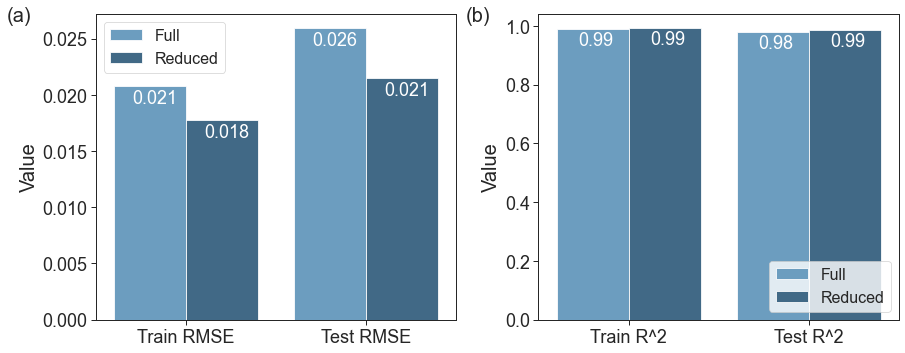

In [51]:
# Plot the RMSE and R2 for both datasets
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(9,3.5))

g1 = sns.barplot(x = 'Metric', y = 'Value', palette = 'Blues_d', hue = 'Dataset', 
                 data = concat_scores_TVD_rmse, ax = axes[0])
g2 = sns.barplot(x = 'Metric', y = 'Value', palette = 'Blues_d', hue = 'Dataset', 
                 data = concat_scores_TVD_r2, ax = axes[1])

### Customize the axes[0] plot
# Customize the RMSE plot
axes[0].set_xlabel('', fontsize = 20)
axes[0].set_ylabel('Value', fontsize = 20)
axes[0].tick_params(labelsize = 18)
axes[0].legend(prop={"size":16}, loc = 0)

### Customize the axes[1] plot
# Customize the R2 plot
axes[1].set_xlabel('', fontsize = 20)
axes[1].set_ylabel('Value', fontsize = 20)
axes[1].tick_params(labelsize = 18)
axes[1].legend(prop={"size":16}, loc = 4)

for p in g1.patches:
    g1.annotate(str(round(p.get_height(),3)), (p.get_x() + 0.1, p.get_height() - 0.0015), 
                fontsize = 18, color = 'white')

for p in g2.patches:
    g2.annotate(str(round(p.get_height(),2)), (p.get_x() + 0.12, p.get_height() - 0.055), 
                fontsize = 18, color = 'white')

# Figure labels
fig.text(-0.003, 1.35, '(a)', va='center', rotation='horizontal', fontsize = 20)
fig.text(0.705, 1.35, '(b)', va='center', rotation='horizontal', fontsize = 20)

x_offset = 0.00
y_offset = 0.00

# set the spacing between subplots 
plt.subplots_adjust(left=0.0, 
                    bottom=0.0,  
                    right=0.9,  
                    top=0.9,  
                    wspace=2,  
                    hspace=0.5)

plt.tight_layout(rect=(0, 0, 1.4, 1.4));

#### Predictions of the reduced dataset for the TVD model

In [52]:
# Make predictions on test data and save them
y_preds_rf_TVD_reduced = ideal_model_rf_TVD_reduced.predict(X_test_TVD_reduced)

# View predictions
y_preds_rf_TVD_reduced

array([0.89975078, 1.14325529, 0.99031275, 1.21691812, 1.04993403,
       1.10985636, 0.73910547, 0.8296441 , 1.26106493, 1.31451389,
       1.02157275, 1.16904053, 1.27855494, 0.73099145, 0.83984375,
       1.16904053, 0.90996272, 1.20161478, 0.97026448, 0.859375  ,
       0.92412502, 0.8296441 , 0.80253011, 1.20021023, 1.30914931,
       1.41077922, 0.89898887, 0.97247138, 0.98740054, 0.9847513 ,
       0.7468589 , 0.859375  , 0.80253011, 0.97970829, 1.05983791,
       1.10671667, 1.24349646, 0.71733565, 0.8135347 , 1.17448074,
       0.89071549, 1.14551367, 0.7550173 , 1.20161478, 1.19758434,
       0.80253011, 0.95137113])

### Figure 7b

(0.6, 1.5)

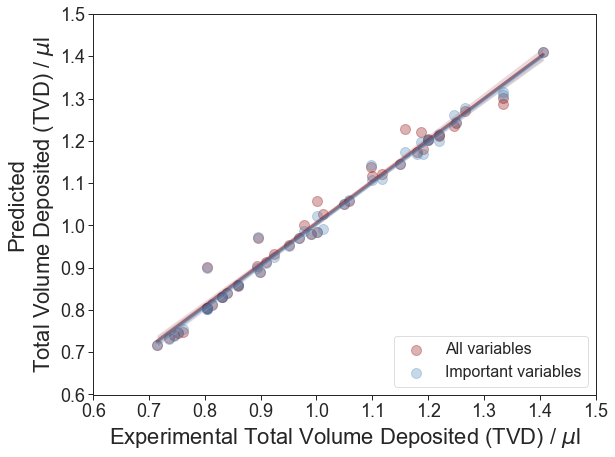

In [53]:
# Plot Y-train vs Y-preds for RFR
fig, ax = plt.subplots(figsize=(9, 7))

sns.regplot(x = y_test_TVD,
            y= y_preds_rf_TVD, scatter_kws={"color":"darkred","alpha":0.3,"s":100}, 
            line_kws={"color":"darkred","alpha":0.5,"lw":3}, label = 'All variables');
sns.regplot(x = y_test_TVD,
            y= y_preds_rf_TVD_reduced, scatter_kws={"color":"steelblue","alpha":0.3,"s":100}, 
            line_kws={"color":"steelblue","alpha":0.5,"lw":3}, label = 'Important variables');

ax.tick_params(labelsize=18)
ax.set_xlabel(r"Experimental Total Volume Deposited (TVD) / $\mu$l",fontsize=22)
ax.set_ylabel(r"Predicted" "\n" "Total Volume Deposited (TVD) / $\mu$l",fontsize=22)
plt.legend(prop={"size":16}, loc = 4)

plt.xticks(np.arange(0.6, 1.6, 0.1))
plt.yticks(np.arange(0.6, 1.6, 0.1))
plt.xlim([0.6, 1.5])
plt.ylim([0.6, 1.5])

### Individual SHAP Value Plot — Local Interpretability
Individual predictions will be made based on the model results and using the SHAP library, which will also allow knowing which input parameters would be required to obtain the predicted Total Volume Deposited.

In [54]:
# Get the predictions and put them with the test data.
X_output_TVD_shap = X_train_TVD_reduced.copy()
X_output_TVD_shap.loc[:,'predict'] = np.round(ideal_model_rf_TVD_reduced.predict(X_output_TVD_shap),2)

# Randomly pick some observations
random_picks = np.arange(1,30,1) # Every 1 rows
S_TVD_shap = X_output_TVD_shap.iloc[random_picks]
S_TVD_shap

,Average Drop Volume (pl),nº of drops,predict
229,225.0,5263.157895,1.18
69,225.0,2770.083102,0.60
168,225.0,4166.666667,0.93
109,190.0,5882.352941,1.11
124,210.0,5000.000000,1.05
79,220.0,3267.973856,0.72
86,212.5,3906.250000,0.83
95,190.0,4081.632653,0.77
219,190.0,6666.666667,1.26
117,190.0,6250.000000,1.20


In [55]:
X_output_TVD_shap.mean()

Average Drop Volume (pl)     203.336957
nº of drops                 4976.595225
predict                        0.996739
dtype: float64

In [56]:
# Function to calculate SHAP force plots based on the predictions on the test set
def shap_plot(j):
    explainerModel = shap.TreeExplainer(ideal_model_rf_TVD_reduced)
    shap_values_Model = explainerModel.shap_values(S_TVD_shap)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], 
                        S_TVD_shap.iloc[[j]], matplotlib = False, 
                        show = False) # set matplotlib to False for JS

    return(p)

### Figure 8a

In [57]:
shap_plot(10)

### Figure 8b

In [58]:
shap_plot(20)

### Figure 9

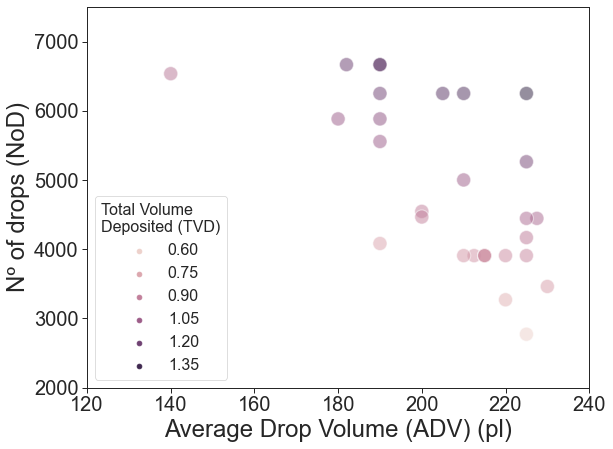

In [59]:
# Represent bubble graph from SHAP predictions
fig, ax = plt.subplots(figsize=(9, 7))

g1 = sns.scatterplot(x = 'Average Drop Volume (pl)', y = 'nº of drops', data = S_TVD_shap, 
                     hue = 'predict', alpha = 0.5, s = 200)


"""g2 = sns.regplot(x = 'Average Drop Volume (pl)', y = 'nº of drops', data = S_TVD, scatter = False, 
                line_kws={"color":"black","alpha":0.5,"lw":3})"""

ax.tick_params(labelsize=20)
ax.set_xlabel("Average Drop Volume (ADV) (pl)",fontsize=24);
ax.set_ylabel("Nº of drops (NoD)",fontsize=24);
#ax.legend(fontsize = 14, loc = 1)

# Call legend twice
color_leg = ax.legend(loc = 3, fontsize = 16, title = 'Total Volume \nDeposited (TVD)', title_fontsize = 16)


plt.xticks(np.arange(120, 250, 20));
plt.yticks(np.arange(1000, 10000, 1000));
plt.xlim([120,240]);
plt.ylim([2000,7500]);